In [3]:
import numpy as np
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy.stats import f_oneway
from collections import defaultdict
from load_data import load_data,get_SG_FR, similarity_metric


True
d:\生科课\计算与系统神经科学\Project\src
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
metadata:{'sex': 'male', 'targeted_structure': 'VISp', 'ophys_experiment_id': 501559087, 'experiment_container_id': 511510736, 'excitation_lambda': '910 nanometers', 'indicator': 'GCaMP6f', 'fov': '400x400 microns (512 x 512 pixels)', 'genotype': 'Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/Ai93(TITL-GCaMP6f)', 'session_start_time': datetime.datetime(2016, 2, 4, 10, 25, 24), 'session_type': 'three_session_B', 'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-222426', 'cre_line': 'Cux2-CreERT2/wt', 'imaging_depth_um': 175, 'age_days': 104, 'device': 'Nikon A1R-MP multiphoton microscope', 'device_name': 'CAM2P.2', 'pipeline_version': '3.0'}
ts shape:(113888,)
dff shape:(174, 113888)
all_roi_masks shape:(174, 512, 512)
cids shape:(174,)
static_gating:
      Unnamed: 0  orientation  spatial_frequency  phase   start     end
0   

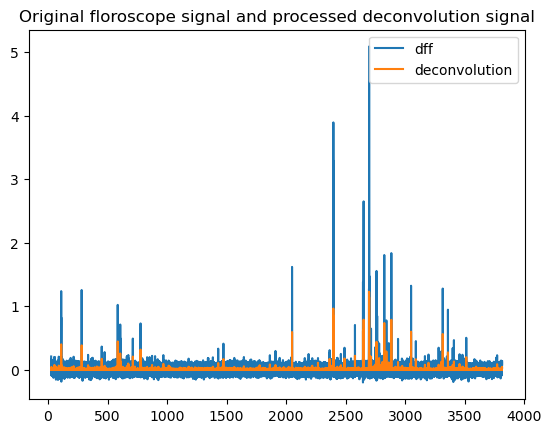

d:\生科课\计算与系统神经科学\Project\src\load_data.py:135: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(firing_data), np.array(ts_data)


In [4]:
tgt_data_path = '../data/VISp_three_session_B_501559087'
print(os.path.exists(tgt_data_path))
print(os.getcwd())
ts, dff, all_roi_masks, cids, metadata, tgt_data = load_data(tgt_data_path)
position = metadata.tolist()
print('================================================')
print('Caution, the position of this file is about the brain part of', position['targeted_structure'])
print('================================================')

orientation, spatial_frequency, phase, firing_data, _ts = get_SG_FR(ts,dff,tgt_data)
# Example data: ./data/VISal_three_session_B_501929146 \n
# ts (Time Seires): 
# (113852,) \n
# dff (dataframe of firing): 
# (172, 113852)  \n
# all_roi_masks (region of interest mask):
# (172, 512, 512) \n
# cids (Cell ids):
# (172,) \n
# metadata: \n
# {'sex': 'male', 'targeted_structure': 'VISal', 'ophys_experiment_id': 501929146, 'experiment_container_id': 511510715, 'excitation_lambda': '910 nanometers', 
# 'indicator': 'GCaMP6f', 'fov': '400x400 microns (512 x 512 pixels)', 'genotype': 'Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/Ai93(TITL-GCaMP6f)', 
# 'session_start_time': datetime.datetime(2016, 2, 11, 9, 54, 37), 'session_type': 'three_session_B', 'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-222426', 
# 'cre_line': 'Cux2-CreERT2/wt', 'imaging_depth_um': 175, 'age_days': 111, 'device': 'Nikon A1R-MP multiphoton microscope', 'device_name': 'CAM2P.2', 'pipeline_version': '3.0'}


Step 1: Feature grouping...
orientation.shape=(5808,),firing_data.shape=(5808, 174),spatial_frequency.shape=(5808,),phase.shape=(5808,)
Step 2: Computing modulation strength...
Grouping data...
Computing ANOVA...
Step 3: Plotting radar charts...


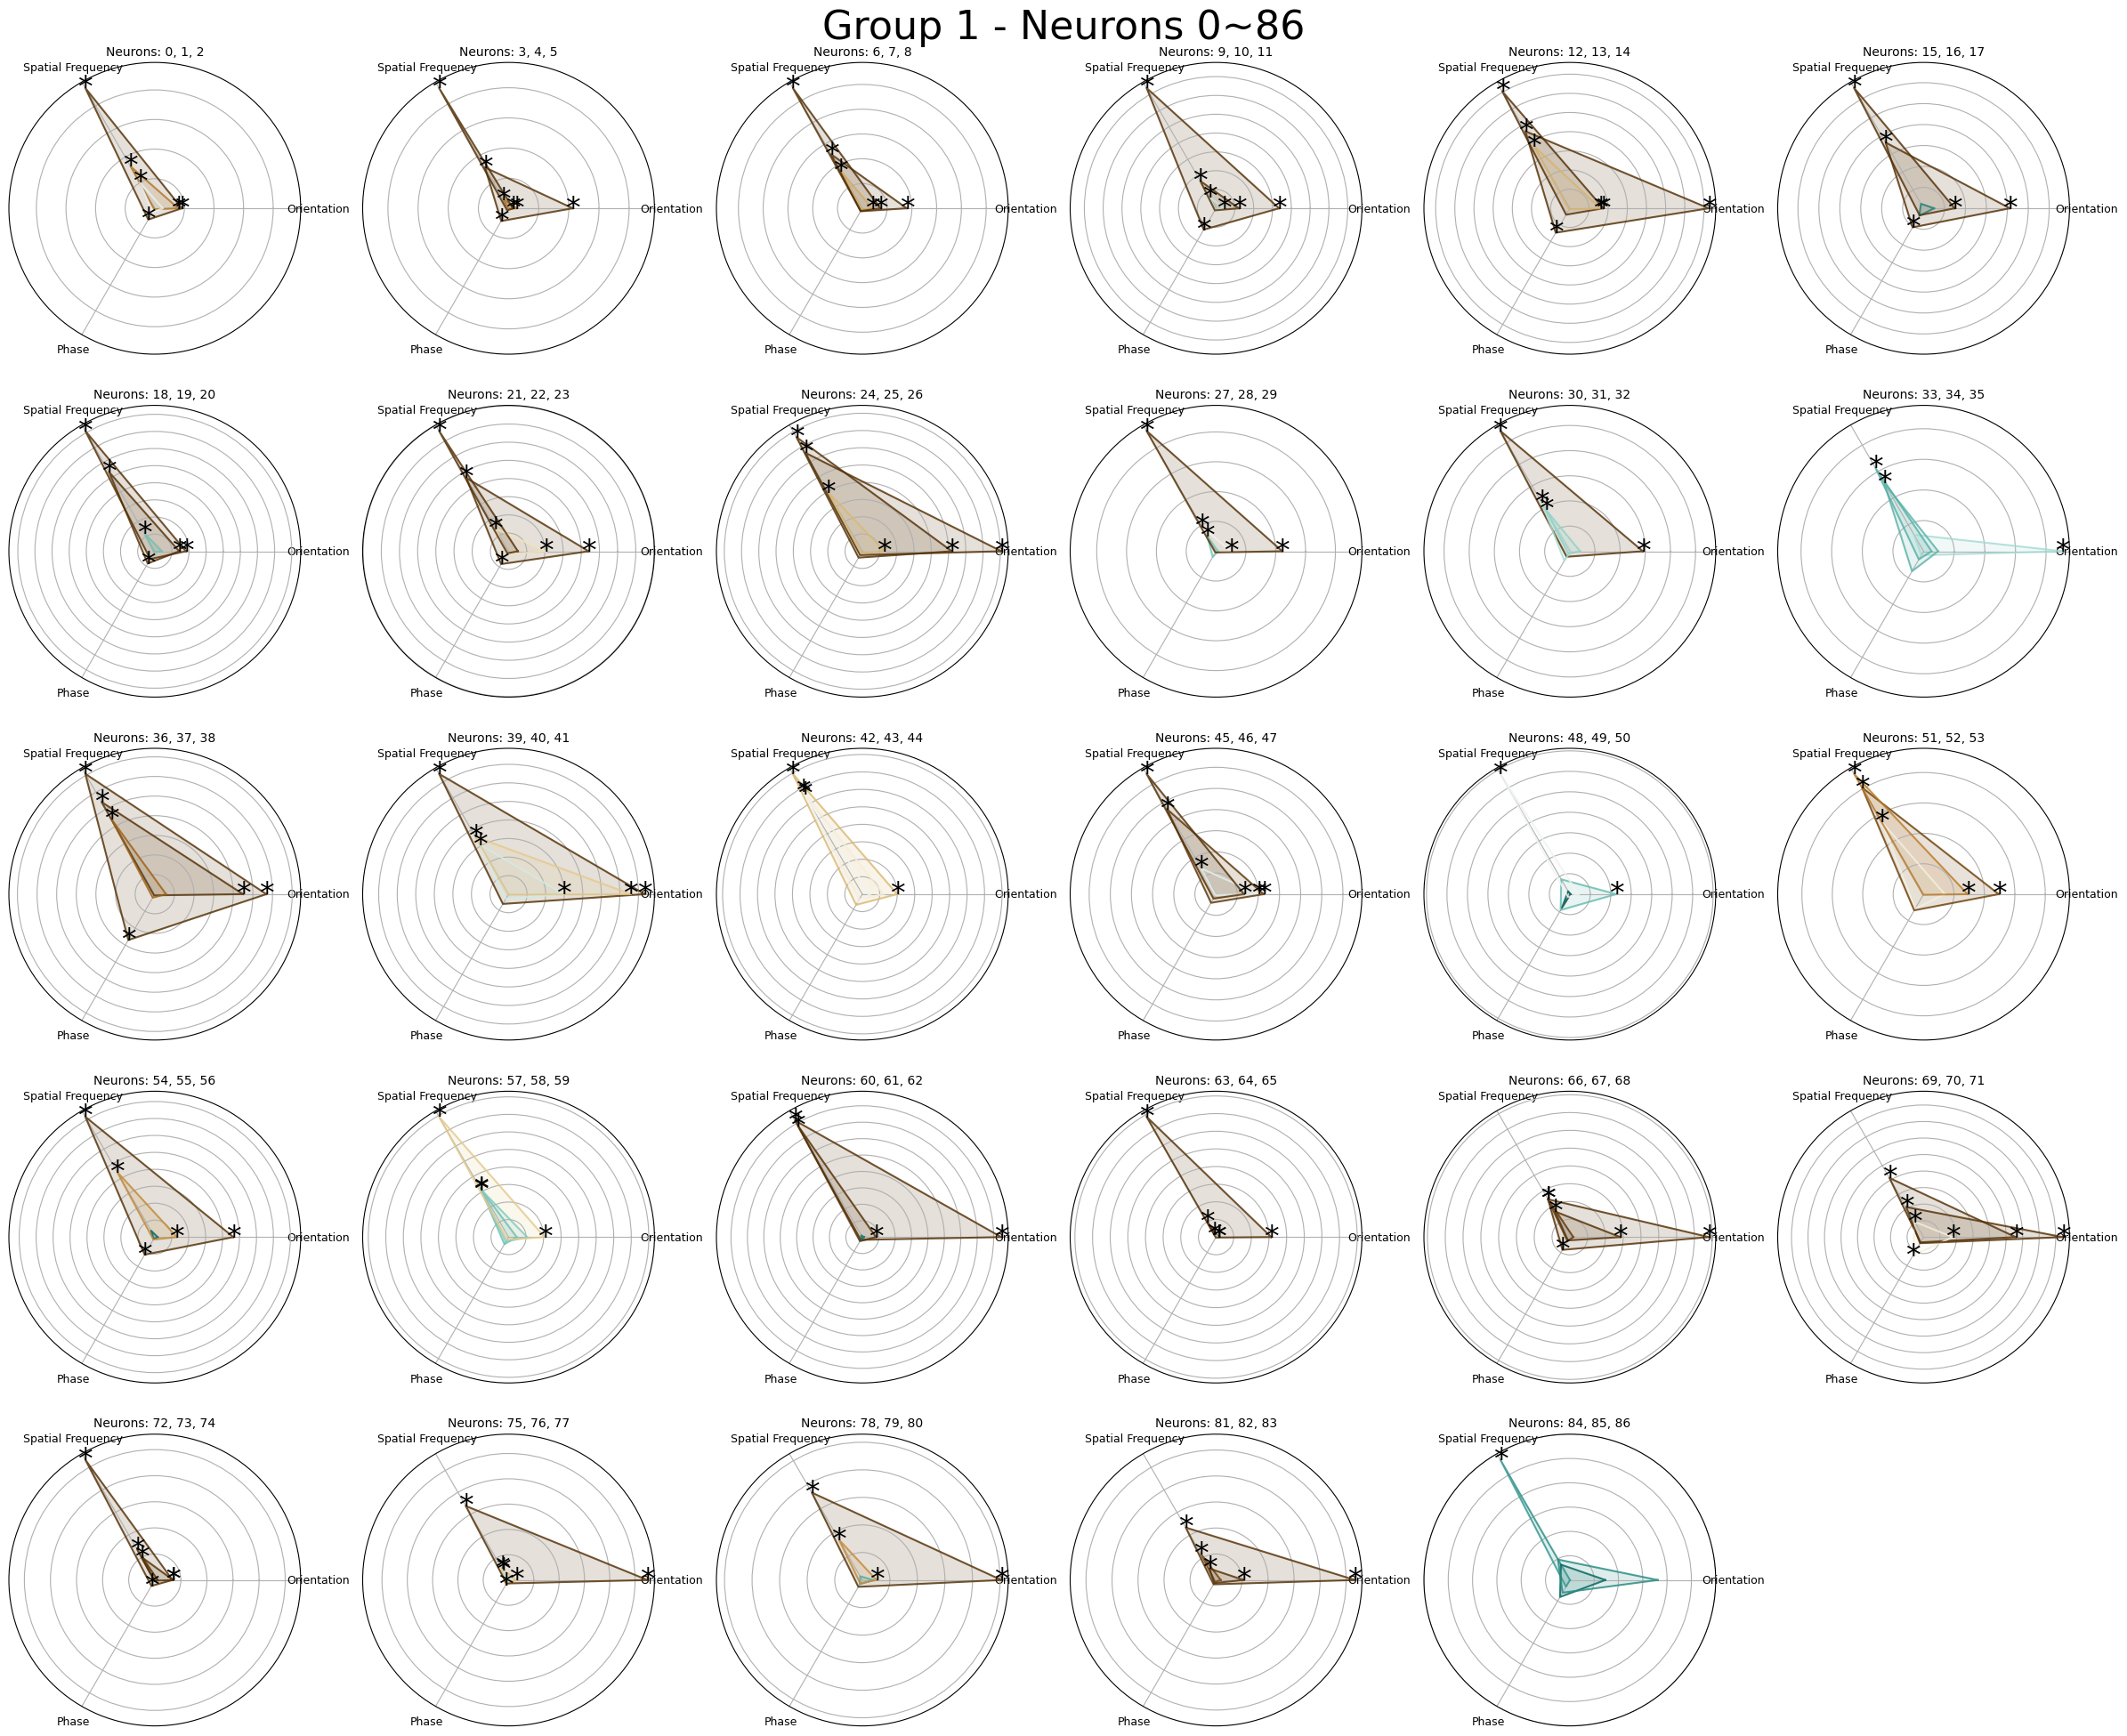

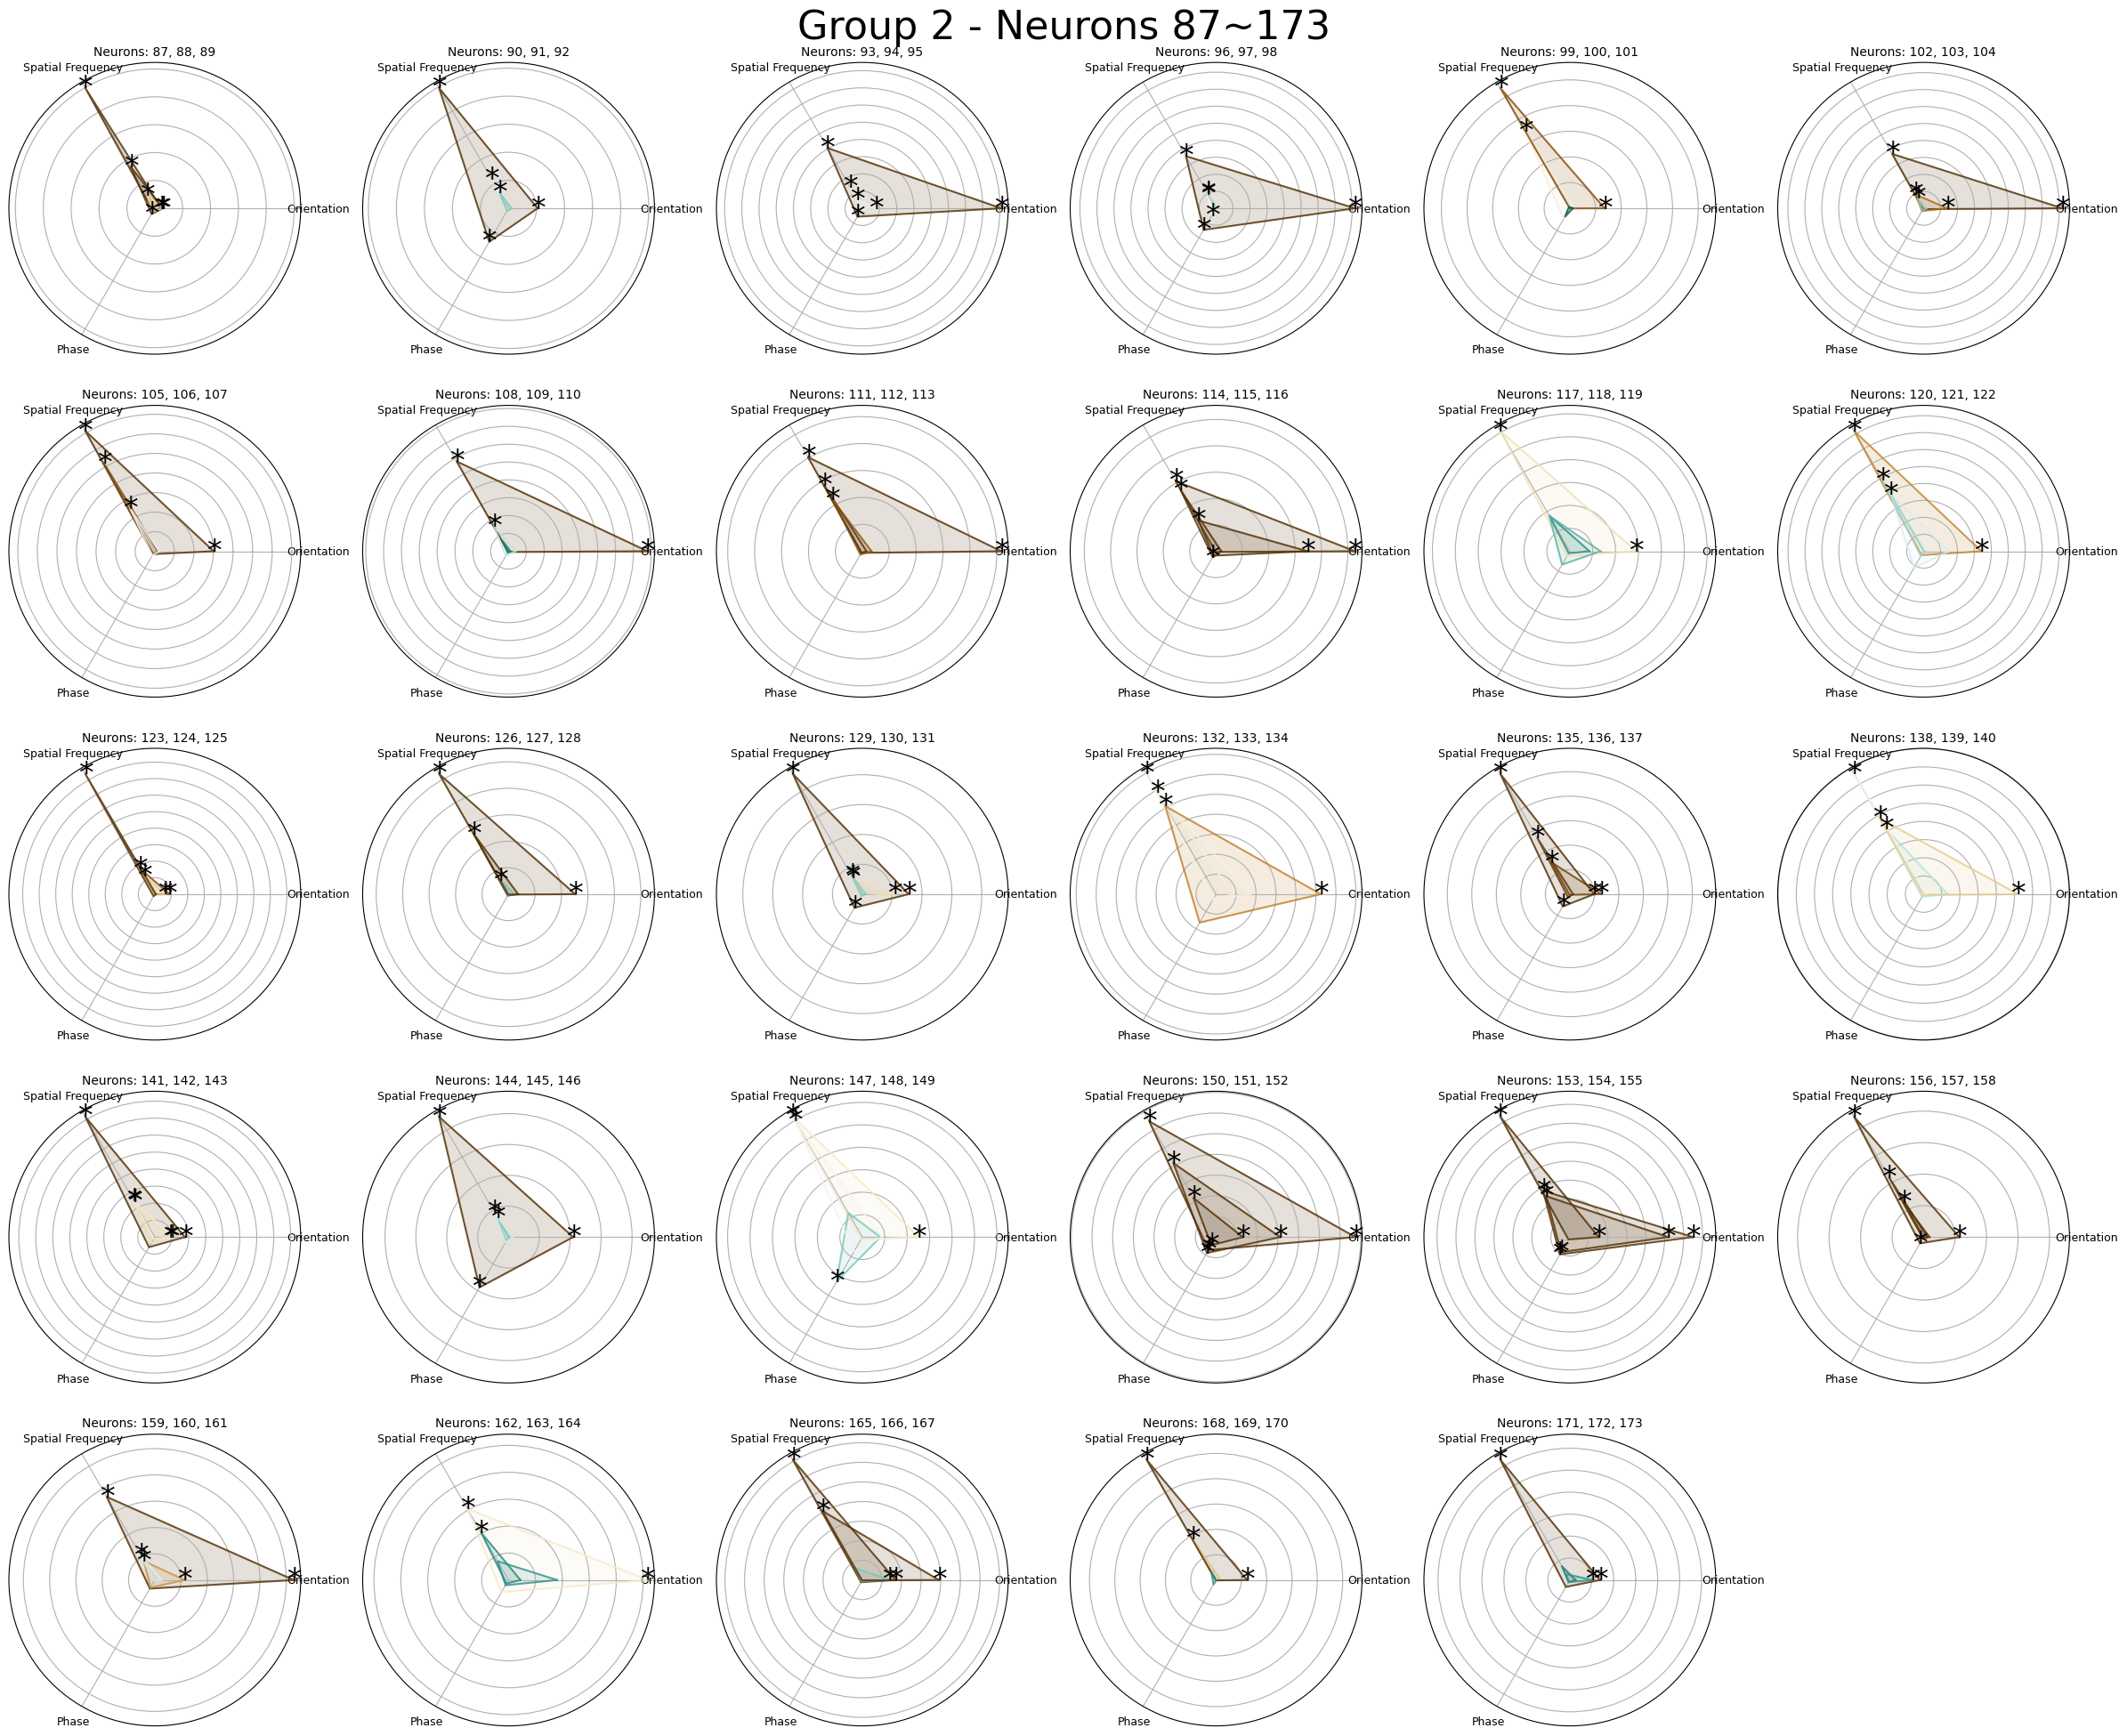

Done!


In [6]:
def extract_feature_lists(firing_data:np.ndarray,orientation:np.ndarray,spatial_frequency:np.ndarray,phase:np.ndarray):
    """
    We have firing data, orientation, spatial_frequency, phase. And we want to calculate for each category, do we have some sort of way to find if there are some relationship between them?
    shape example:
    (5805,) (5805, 172) (5805,) (5805,)
    orientation = np.array([0, 30, 60, 90, 120, 150])
    spatial_frequency = np.array([0.02, 0.04, 0.08, 0.16, 0.32])
    phase = np.array([0, 0.25, 0.5, 0.75])
    Thus, there are 6*5*4 = 120 categories.
    """
    print(f'orientation.shape={orientation.shape},firing_data.shape={firing_data.shape},spatial_frequency.shape={spatial_frequency.shape},phase.shape={phase.shape}')
    firing_datas = []
    for orientation_ in np.unique(orientation):
        for spatial_frequency_ in np.unique(spatial_frequency):
            for phase_ in np.unique(phase):
                index = np.where((orientation==orientation_)&(spatial_frequency==spatial_frequency_)&(phase==phase_))
                firing_data_ = firing_data[index]
                firing_datas.append([firing_data_,orientation_,spatial_frequency_,phase_])
    return firing_datas

def similarity_metric(firing_datas, N_neurons):
    modulation = {
        'orientation': np.zeros(N_neurons),
        'spatial_frequency': np.zeros(N_neurons),
        'phase': np.zeros(N_neurons)
    }
    
    print("Grouping data...")
    group_orientation = defaultdict(list)
    group_spatial_frequency = defaultdict(list)
    group_phase = defaultdict(list)

    for j in range(len(firing_datas)):
        o, s, p = firing_datas[j][1], firing_datas[j][2], firing_datas[j][3]
        responses = firing_datas[j][0]
        for i in range(N_neurons):
            group_orientation[(o, i)].extend(responses[:, i])
            group_spatial_frequency[(s, i)].extend(responses[:, i])
            group_phase[(p, i)].extend(responses[:, i])

    print("Computing ANOVA...")
    for i in range(N_neurons):
        # Orientation
        groups = [group_orientation[(k, i)] for k in np.unique(orientation)]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            _, p = f_oneway(*groups)
            modulation['orientation'][i] = -np.log10(p)

        # Spatial Frequency
        groups = [group_spatial_frequency[(k, i)] for k in np.unique(spatial_frequency)]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            _, p = f_oneway(*groups)
            modulation['spatial_frequency'][i] = -np.log10(p)

        # Phase
        groups = [group_phase[(k, i)] for k in np.unique(phase)]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            _, p = f_oneway(*groups)
            modulation['phase'][i] = -np.log10(p)

    return modulation

def plot_modulation_radar_tiled(modulation, neuron_indices,
                                neurons_per_subplot=3,
                                subplots_per_fig=(5, 6),
                                cmap='BrBG_r',
                                title=None,
                                sig_threshold=2):  # -log10(0.01) = 2
    """
    在多个子图中批量展示神经元的调制雷达图，每个子图可以叠加多个神经元
    
    参数:
        modulation: dict，包含 orientation / sf / phase 的调制强度 (-log10(p))
        neuron_indices: list of int，要绘制的神经元编号
        neurons_per_subplot: 每个子图最多显示多少个神经元（默认 3）
        subplots_per_fig: 每张图有多少个子图（行数 x 列数），默认 (5, 6)
        cmap: 颜色映射
        title: 图表标题
        sig_threshold: 显著性阈值，默认 2（即 p < 0.01）
    """
    labels = np.array(['Orientation', 'Spatial Frequency', 'Phase'])
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    total_subplots_needed = (len(neuron_indices) + neurons_per_subplot - 1) // neurons_per_subplot
    rows, cols = subplots_per_fig
    subplots_per_figure = rows * cols

    for fig_idx in range(0, total_subplots_needed, subplots_per_figure):
        fig_start = fig_idx
        fig_end = min(fig_idx + subplots_per_figure, total_subplots_needed)
        current_batches = [neuron_indices[i*neurons_per_subplot : (i+1)*neurons_per_subplot]
                           for i in range(fig_start, fig_end)]

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), subplot_kw=dict(polar=True))
        if rows == 1 and cols > 1:
            axes = axes.reshape(1, -1)
        elif cols == 1 and rows > 1:
            axes = axes.reshape(-1, 1)

        norm = Normalize(vmin=0, vmax=5)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        for ax_idx, batch in enumerate(current_batches):
            ax = axes[ax_idx // cols, ax_idx % cols]
            title_parts = []

            for idx in batch:
                stats = np.array([
                    modulation['orientation'][idx],
                    modulation['spatial_frequency'][idx],
                    modulation['phase'][idx]
                ])
                stats = np.concatenate((stats, [stats[0]]))  # Close the radar chart

                color = sm.to_rgba(stats[:-1].mean())
                ax.plot(angles, stats, color=color, linewidth=1.5, alpha=0.8, label=f"Neuron {idx}")
                ax.fill(angles, stats, color=color, alpha=0.15)
                title_parts.append(f"{idx}")

                # 添加显著性标记 ★
                for i in range(num_vars):
                    if stats[i] > sig_threshold:
                        ax.text(angles[i], stats[i], '*', fontsize=24, ha='center', va='center')
                        # ax.plot(angles[i], stats[i], marker='*', markersize=10, color='red', linestyle='none')

            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(labels, fontsize=9)
            ax.set_yticklabels([])
            ax.set_title("Neurons: " + ", ".join(title_parts), fontsize=10)

        # 关闭多余的子图
        for ax_idx in range(len(current_batches), rows * cols):
            fig.delaxes(axes.flatten()[ax_idx])

        if title is not None:
            fig.suptitle(title, fontsize=32)
        else:
            fig.suptitle(f"Modulation Profiles - Batch {fig_idx // subplots_per_figure + 1}", fontsize=32)

        fig.tight_layout()
        plt.show()


print("Step 1: Feature grouping...")
firing_datas = extract_feature_lists(firing_data, orientation, spatial_frequency, phase)
print("Step 2: Computing modulation strength...")
modulation = similarity_metric(firing_datas, N_neurons=firing_data.shape[1])
print("Step 3: Plotting radar charts...")
group1 = list(range(0, firing_data.shape[1]//2))
group2 = list(range(firing_data.shape[1]//2, firing_data.shape[1]))
plot_modulation_radar_tiled(modulation, group1, title=f"Group 1 - Neurons 0~{firing_data.shape[1]//2-1}")
plot_modulation_radar_tiled(modulation, group2, title=f"Group 2 - Neurons {firing_data.shape[1]//2}~{firing_data.shape[1]-1}")
print("Done!")

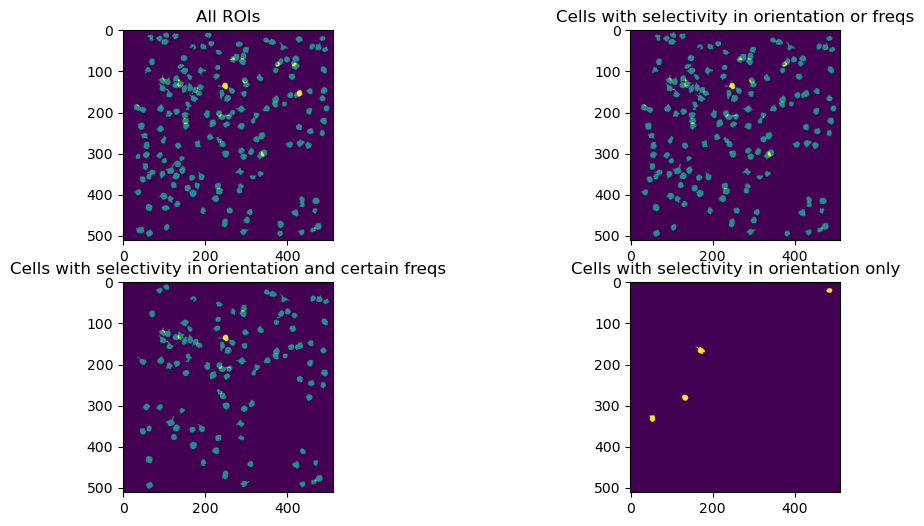

In [7]:
positions = all_roi_masks # 172*500*500
# modulation = {
#         'orientation': np.zeros(N_neurons),
#         'spatial_frequency': np.zeros(N_neurons),
#         'phase': np.zeros(N_neurons)
#     }
N_neurons = len(modulation['orientation'])
selective_cell_indexs = [idx  for idx in range(N_neurons) if modulation['orientation'][idx] > 2 or modulation['spatial_frequency'][idx] > 2]
simple_cells_indexs = [idx  for idx in range(N_neurons) if modulation['orientation'][idx] > 2 and modulation['spatial_frequency'][idx] > 2] # selective in spatial frequency
complex_cells_indexs = [idx  for idx in range(N_neurons) if modulation['orientation'][idx] > 2 and modulation['spatial_frequency'][idx] < 2] # not selective in spatial frequency

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,6))
ax1.imshow(np.sum(all_roi_masks,axis=0))
ax1.set_title('All ROIs')
ax2.imshow(np.sum(all_roi_masks[selective_cell_indexs],axis=0))
ax2.set_title('Cells with selectivity in orientation or freqs')
ax3.imshow(np.sum(all_roi_masks[simple_cells_indexs],axis=0))
ax3.set_title('Cells with selectivity in orientation and certain freqs')
ax4.imshow(np.sum(all_roi_masks[complex_cells_indexs],axis=0))
ax4.set_title('Cells with selectivity in orientation only')
plt.show()


